In [21]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

from sklearn.datasets import make_biclusters
from sklearn.datasets import samples_generator as sg
from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.metrics import consensus_score
import pandas as pd

r = pd.read_csv( 'ratings.csv' )
tr = pd.read_csv( 'to_read.csv' )
b = pd.read_csv( 'books.csv' )

t = pd.read_csv( 'tags.csv' )
bt = pd.read_csv( 'book_tags.csv')


### Ratings

In [2]:
r.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


Ratings are sorted chronologically, oldest first.

In [3]:
len(r)

5976479

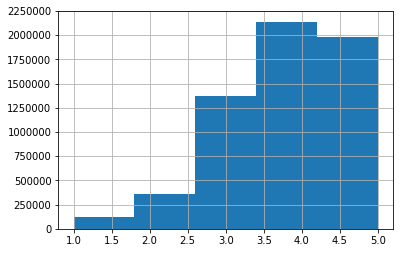

In [4]:
r.rating.hist( bins = 5 )

It appears that 4 is the most popular rating. There are relatively few ones and twos.

### To read
These are the books users marked "to read".


In [5]:
tr.head()

,user_id,book_id
0,9,8
1,15,398
2,15,275
3,37,7173
4,34,380


In [6]:
len(tr)

912705

Most books have been marked to read by somebody. Majority of the users have some books marked to read.

In [7]:
len(tr.book_id.unique())

9986

In [8]:
len(tr.user_id.unique())

48871

### Books

In [9]:
b.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


Books are sorted by their popularity, as measured by number of ratings (overall, not in this dataset).

In [10]:
len(b)

10000

### User and book IDs

In [11]:
r.user_id.max()

53424

In [12]:
r.book_id.max()

10000

The IDs are contiguous.

In [13]:
assert( len( r.user_id.unique()) == r.user_id.max())
assert( len( r.book_id.unique()) == r.book_id.max())

### Reviews per book

Most books have a few hundred reviews, but some have as few as eight.

In [14]:
reviews_per_book = r.groupby( 'book_id' ).book_id.apply( lambda x: len( x ))
reviews_per_book.describe()

count    10000.000000
mean       597.647900
std       1267.289788
min          8.000000
25%        155.000000
50%        248.000000
75%        503.000000
max      22806.000000
Name: book_id, dtype: float64

In [15]:
reviews_per_book.sort_values().head( 10 )

book_id
7803     8
9345    11
9486    24
1935    33
9315    36
9553    41
8181    45
9479    48
9260    48
9705    50
Name: book_id, dtype: int64

### Reviews per user

All users have at least 19 reviews.

In [16]:
reviews_per_user = r.groupby( 'user_id' ).user_id.apply( lambda x: len( x ))
reviews_per_user.describe()

count    53424.000000
mean       111.868804
std         26.071224
min         19.000000
25%         96.000000
50%        111.000000
75%        128.000000
max        200.000000
Name: user_id, dtype: float64

In [17]:
reviews_per_user.sort_values().head( 10 )

user_id
34590    19
43675    20
40753    21
51725    21
32128    21
37640    22
16470    22
42736    22
48077    22
40299    22
Name: user_id, dtype: int64

### Tags

In [18]:
t.head()

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


In [19]:
len(t)

34252

In [20]:
bt.head()

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


Tag applications are sorted by goodreads_book_id ASC and by count DESC.

In [21]:
len(bt)

999912

Let us merge tag names into tag applications.

In [22]:
bt = bt.merge( t, on = 'tag_id' )

Why don't we merge book titles for good measure.

In [23]:
bt = bt.merge( b[[ 'goodreads_book_id', 'title']], on = 'goodreads_book_id' )

It appears that there are some negative tag counts. Let's fix this.

In [24]:
bt['count'].describe()

count    999912.000000
mean        208.869633
std        3501.265173
min          -1.000000
25%           7.000000
50%          15.000000
75%          40.000000
max      596234.000000
Name: count, dtype: float64

In [25]:
bt.loc[ bt['count'] < 0, 'count'] = 0

Sample some popular book tags.

In [26]:
bt.sample( 10, weights = 'count')

,goodreads_book_id,tag_id,count,tag_name,title
717185,7817785,19712,86,melissa-de-la-cruz,"Bloody Valentine (Blue Bloods, #5.5)"
660294,6218007,30574,23409,to-read,"Kimi ni Todoke: From Me to You, Vol. 1"
278700,60510,30574,19818,to-read,"Poison Study (Study, #1)"
876594,16181775,30574,31065,to-read,"The Rosie Project (Don Tillman, #1)"
17700,2187,30574,299006,to-read,Middlesex
696094,7059135,30574,51264,to-read,"Inside Out (Insider, #1)"
855294,15802944,30574,20586,to-read,"Carry On, Warrior: Thoughts on Life Unarmed"
348910,99329,9221,45,default,"The History of Tom Jones, a Foundling"
666194,6342491,30574,95926,to-read,"The Demon King (Seven Realms, #1)"
853094,15790842,30574,18733,to-read,Life After Life


These are the most popular tags:

In [27]:
tag_counts = bt.groupby( 'tag_name' ).tag_name.count().sort_values( ascending = False )
tag_counts.head( 20 )

tag_name
to-read              9983
favorites            9881
owned                9858
books-i-own          9799
currently-reading    9776
library              9415
owned-books          9221
fiction              9097
to-buy               8692
kindle               8316
default              8239
ebook                8054
my-books             7561
audiobook            7242
ebooks               7203
wish-list            7192
my-library           7000
audiobooks           6862
i-own                6670
adult                6604
Name: tag_name, dtype: int64

In [25]:
r = r.sort_values(by=['user_id'])

In [11]:
bookDF=pd.read_csv('books.csv')
bookDF=bookDF.drop(['image_url','small_image_url','title','best_book_id','isbn','isbn13'],axis=1)

In [15]:
bookDF.head()

,book_id,goodreads_book_id,work_id,books_count,authors,original_publication_year,original_title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
0,1,2767052,2792775,272,Suzanne Collins,2008.0,The Hunger Games,eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317
1,2,3,4640799,491,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543
2,3,41865,3212258,226,Stephenie Meyer,2005.0,Twilight,en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439
3,4,2657,3275794,487,Harper Lee,1960.0,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267
4,5,4671,245494,1356,F. Scott Fitzgerald,1925.0,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718


In [5]:
listOfDictonaries=[]
indexMap = {}
reverseIndexMap = {}
ptr=0;
testdf = r
testdf=testdf[['user_id','rating']].groupby(testdf['book_id'])
for groupKey in testdf.groups.keys():
    tempDict={}

    groupDF = testdf.get_group(groupKey)
    for i in range(0,len(groupDF)):
        tempDict[groupDF.iloc[i,0]]=groupDF.iloc[i,1]
    indexMap[ptr]=groupKey
    reverseIndexMap[groupKey] = ptr
    ptr=ptr+1
    listOfDictonaries.append(tempDict)

In [43]:
testdf.groups.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

In [6]:
from sklearn.feature_extraction import DictVectorizer
dictVectorizer = DictVectorizer(sparse=True)
vector = dictVectorizer.fit_transform(listOfDictonaries)

In [7]:
from sklearn.metrics.pairwise import cosine_similarity
pairwiseSimilarity = cosine_similarity(vector)

In [16]:
def printBookDetails(bookID):
    print("Title:", bookDF[bookDF['book_id']==bookID]['original_title'].values[0])
    print("Author:",bookDF[bookDF['book_id']==bookID]['authors'].values[0])
    print("Printing Book-ID:",bookID)
    print("=================++++++++++++++=========================")


def getTopRecommandations(bookID):
    row = reverseIndexMap[bookID]
    print("------INPUT BOOK--------")
    printBookDetails(bookID)
    print("-------RECOMMENDATIONS----------")
    similarBookIDs = [printBookDetails(indexMap[i]) for i in np.argsort(pairwiseSimilarity[row])[-7:-2][::-1]]

In [19]:
getTopRecommandations(111)

------INPUT BOOK--------
Title: The Memory Keeper's Daughter
Author: Kim Edwards
Printing Book-ID: 111
=================++++++++++++++=========================
-------RECOMMENDATIONS----------
Title: The Lovely Bones
Author: Alice Sebold
Printing Book-ID: 22
=================++++++++++++++=========================
Title: Water for Elephants
Author: Sara Gruen
Printing Book-ID: 46
=================++++++++++++++=========================
Title: My Sister's Keeper
Author: Jodi Picoult
Printing Book-ID: 64
=================++++++++++++++=========================
Title: The Help
Author: Kathryn Stockett
Printing Book-ID: 31
=================++++++++++++++=========================
Title: The Kite Runner 
Author: Khaled Hosseini
Printing Book-ID: 11
=================++++++++++++++=========================


In [20]:
pairwiseSimilarity.shape

(10000, 10000)

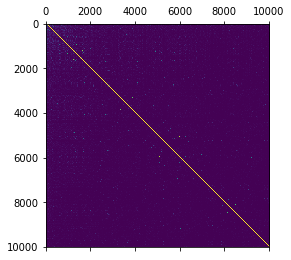

In [22]:
plt.matshow(pairwiseSimilarity)

In [25]:
import scipy.cluster.hierarchy as hcl
from scipy.spatial.distance import squareform

In [28]:
for i in range(0,1000):
    pairwiseSimilarity[i][i] = 0

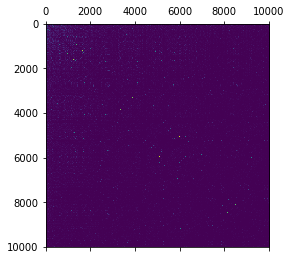

In [37]:
plt.matshow(pairwiseSimilarity)

In [38]:
h = hcl.linkage(squareform(pairwiseSimilarity))

In [40]:
h[0]

array([1.400e+01, 9.857e+03, 0.000e+00, 2.000e+00])

In [7]:
data = np.zeros([len(r.values), max(r['book_id']) + 1])

In [8]:
for row in r.values:
    data[row[0]][row[1]] = row[2]

In [9]:
data[0]

array([0., 0., 0., ..., 0., 0., 0.])

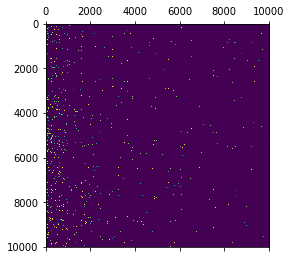

In [10]:
plt.matshow(data[:10000])

In [1]:
from scipy import sparse

In [ ]:
sp_data = sparse.csr_matrix(data)